# Tell me about the world

> Created: 2021-01-27

A short demonstration using
[pkg-json](https://gnu-octave.github.io/pkg-index/package/pkg-json)
with GNU Octave to plot a simplified two dimensional political
["World Map"](https://data.nasa.gov/dataset/World-Map/7zbq-j77a)
from public available JSON data provided by the
[NASA](https://en.wikipedia.org/wiki/NASA).
The following code can be used, to easily visualize data divided by countries
(e.g. population densities, health data, economic figures, tax, export, etc.).

## The code at a glance

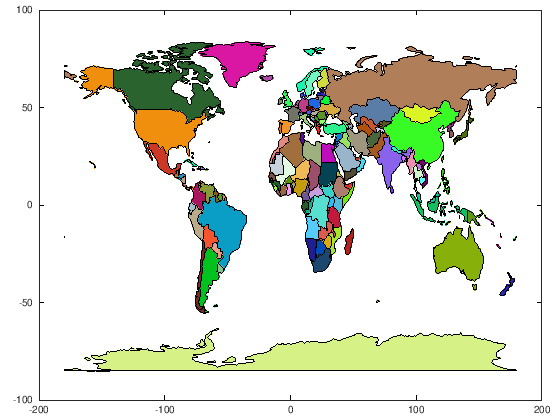

In [1]:
%% Step 1: Install and load pkg-json.
if (isempty (pkg ("list", "pkg-json")))
  pkg install "https://github.com/gnu-octave/pkg-json/archive/v1.0.0.tar.gz"
end

pkg load pkg-json

%% Step 2: Define a helper function to plot an individual country.
function plot_country (name, color, countries, obj)
  idx = find (strcmp (name, countries));
  if (isempty (idx))
    error ("Country ''%s' not found.", name);
  end
  data_str = obj.data(idx){1}(10){1};
  data_str = data_str((1 + length("MULTIPOLYGON (((")):(end - 3));
  data_str = strsplit (data_str, ")), ((");
  for i = 1:length (data_str)
    data = textscan (data_str{i}, "%f %f,");
    fill (data{:,1}, data{:,2}, color);
    hold on;
  end
end

%% Step 3: Download the public data set.
json_str = urlread ("https://data.nasa.gov/api/views/yqhp-cuk8/rows.json?accessType=DOWNLOAD");

%% Step 4: Import JSON data to GNU Octave.
obj = jsondecode (json_str);

%% Step 5: Extract the country names.
countries = cell(length (obj.data), 1);
for i = 1:length (obj.data)
  countries{i} = obj.data(i){1}(9){1};
end

%% Step 6: Plot all available countries with random color.
for i = 1:length (countries)
    plot_country (countries{i}, rand (3,1), countries, obj)
end

## The code explained

**Step 3:** Using `urlread` it is really straight forward to import the data
provided by the NASA into a string.

In [2]:
json_str = urlread ("https://data.nasa.gov/api/views/yqhp-cuk8/rows.json?accessType=DOWNLOAD");

In [3]:
printf ("The string contains %.2f KB of data.", length (json_str) / 1024)

The string contains 253.02 KB of data.

**Step 4:** Thanks to
[Abdalla's Google Summer of Code project](https://abdallahshamy.wordpress.com/2020/08/28/google-summer-of-code-2020-with-gnu-octave-final-report/)
the JSON data is available for further Octave processing with a single function
call.

In [4]:
tic;
obj = jsondecode (json_str);
toc;

Elapsed time is 0.0160789 seconds.


The `jsondecode` function can of course not know about the structure
of the NASA map data itself, thus it is necessary to explore the imported data
using Octave.

The first step is to simply output the content of `obj`, which is quite verbose
and thus omitted here.

As JSON is a structured data format, most of the content is converted to Octave
structures.
A handy function to get an overview of Octave structures is `fieldnames`.

In [5]:
fieldnames (obj)

ans =
{
  [1,1] = meta
  [2,1] = data
}



A splitting into a `meta` and `data` section can be observed.
Some further investigation of the `meta` section revealed,
that it is not very useful for the purpose of plotting the world map,
thus it is not further explained here.

On the other hand the `data` section contains the desired polygon edge data
of the several country borders.

**Step 5:** For the sake of convenience, the names of the individual countries
are exported into an cell array of strings.

In [6]:
countries = cell(length (obj.data), 1);
for i = 1:length (obj.data)
  countries{i} = obj.data(i){1}(9){1};
end

With this approach,
it is easy to map a country name to an index in `obj.data`,
which is examined in the following for "Japan".

In [7]:
japan = find (strcmp (countries, "Japan"))
usa   = find (strcmp (countries, "United States of America"))

japan =  88
usa =  173


In [8]:
obj.data(japan)

ans =
{
  [1,1] =
  {
    [1,1] = row-bxsn-brky.azms
    [2,1] = 00000000-0000-0000-1E4A-C7232D9BDD99
    [3,1] = 0
    [4,1] =  1495517988
    [5,1] = [](0x0)
    [6,1] =  1495517988
    [7,1] = [](0x0)
    [8,1] = { }
    [9,1] = Japan
    [10,1] = MULTIPOLYGON (((134.638428 34.149234, 134.766379 33.806335, 134.203416 33.201178, 133.79295 33.521985, 133.280268 33.28957, 133.014858 32.704567, 132.363115 32.989382, 132.371176 33.463642, 132.924373 34.060299, 133.492968 33.944621, 133.904106 34.364931, 134.638428 34.149234)), ((140.976388 37.142074, 140.59977 36.343983, 140.774074 35.842877, 140.253279 35.138114, 138.975528 34.6676, 137.217599 34.606286, 135.792983 33.464805, 135.120983 33.849071, 135.079435 34.596545, 133.340316 34.375938, 132.156771 33.904933, 130.986145 33.885761, 132.000036 33.149992, 131.33279 31.450355, 130.686318 31.029579, 130.20242 31.418238, 130.447676 32.319475, 129.814692 32.61031, 129.408463 33.296056, 130.353935 33.604151, 130.878451 34.232743, 131.884229 

From this data about Japan, we are only interested in the 10th entry,
defining the "MULTIPOLYGON" data about three larger Japanese islands (areas).
The format is as follows:

```
MULTIPOLYGON (
  ((x1 y1, x2 y2, ...))    // Area 1
  ((x1 y1, x2 y2, ...))    // Area 2
  ...
)
```

Using some straight forward Octave instructions,
this sub format of the JSON data can be further processed by Octave.

In [9]:
%% Extract the 10th data entry.
data_str = obj.data(japan){1}(10){1};
%% Strip start and end of the numerical data.
data_str = data_str((1 + length("MULTIPOLYGON (((")):(end - 3));
%% Split area data into individual cells of an array.
data_str = strsplit (data_str, ")), ((");

The data in the three cells is still of type "string"
and can finally be converted using `textscan` for example.

Now the x,y-data for the edges of each area is available in numerical form
and can be simply plotted by Octave's `fill` function in the same loop.

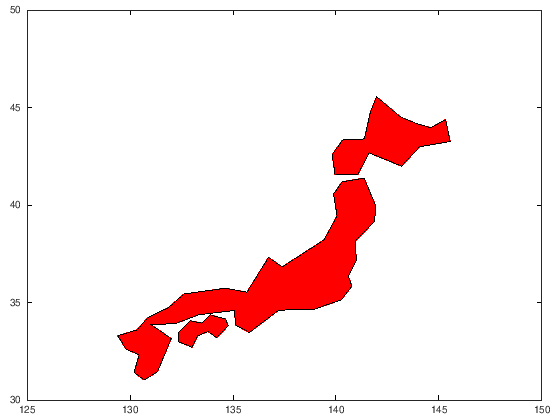

In [10]:
for i = 1:length (data_str)
  data = textscan (data_str{i}, "%f %f,");
  fill (data{:,1}, data{:,2}, "r");
  hold on;
end

**Step 2:** All steps above can conveniently be abstracted into a single
function `plot_country`, defined in the first code section of this notebook.

A second more simplified function call will look like this,
where `countries` is obtained by **Step 5** and `obj` by **Step 4**.
`"g"` (= "green") is the color that should used.

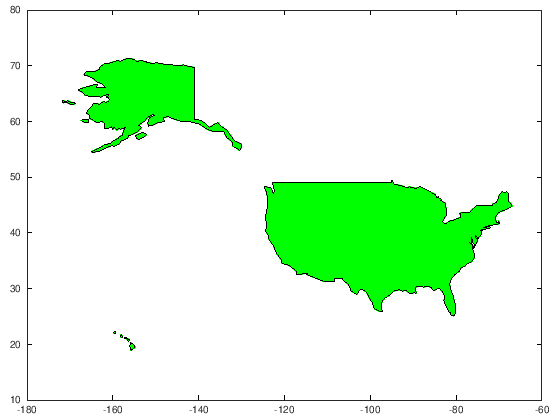

In [11]:
plot_country ("United States of America", "g", countries, obj)

In **Step 6** an example was given how all available countries can be plotted.